In [1]:
import os.path
import types
import math
import yaml
import phacsl.utils.formats.csv_tools as csv_tools
import phacsl.utils.formats.yaml_tools as yaml_tools

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize

def loadCSVByAbbrev(modelDir, fname, key=None):
    if key is None:
        key = 'abbrev'
    fullName = os.path.join(modelDir, fname)
    with open(fullName) as fl:
        keys, recs = csv_tools.parseCSV(fl)
    assert key in keys, ('%s has no "%s" field' % (fullName, key))
    return {rec[key]: rec for rec in recs}

def typeCheck(val):
    return (type(val) in [types.FloatType, types.IntType]) 

modelDir = '/home/welling/git/pyrhea/models/ChicagoLand'

allKeySet, recs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfacts'))
facDict = {r['abbrev']:r for r in recs}

kL, uRecs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfactsUpdated'))
updatedFacDict= {r['abbrev']:r for r in uRecs}


In [2]:
isHospital = [k for k, rec in facDict.items() if rec['category']=='HOSPITAL']


In [46]:
def getVal(abbrev, key):
    if key == 'totalTransfersOut':
        if key in facDict[abbrev]:
            return sum([d['count']['value'] for d in facDict[abbrev][key]])
        else:
            return None
    else:
        if key in facDict[abbrev]:
            return float(facDict[abbrev][key]['value'])
        else:
            return None

def checkPairValid(val, prov):
    for s in ['average', 'median', 'regression', 'slope']:
        if s in prov.lower():
            return False
    if val == 0:
        return False
    return True
    
def checkValid(abbrev, key):
    if key == 'totalTransfersOut':
        for hook in facDict[abbrev][key]:
            if not checkPairValid(hook['value'], hook['prov']):
                return False
        return True
    else:
        hook = facDict[abbrev][key]
        return checkPairValid(hook['value'], hook['prov'])


In [4]:
def findThoseWith(key):
    if key == 'totalTransfersOut':
        return [k for k in isHospital if key in facDict[k]]
    else:
        return [k for k in isHospital if key in facDict[k] and typeCheck(facDict[k][key]['value'])]


In [5]:
def findThoseWithout(key):
    l = findThoseWith(key)
    return [k for k in isHospital if k not in l]

In [35]:
def findThoseWithoutValid(key):
    noneL = findThoseWithout(key)
    withL = findThoseWith(key)
    fakeL = [k for k in withL if not checkValid(k, key)]
    return noneL + fakeL


In [32]:
def findThoseWithValid(key):
    withL = findThoseWith(key)
    validL = [k for k in withL if checkValid(k, key)]
    return validL


In [33]:
s1 = set(findThoseWithValid('fracAdultPatientDaysICU'))
s2 = set(findThoseWithoutValid('fracAdultPatientDaysICU'))
hospSet = set(isHospital)
print s1.intersection(s2)
print hospSet == s1.union(s2)


set([])
True


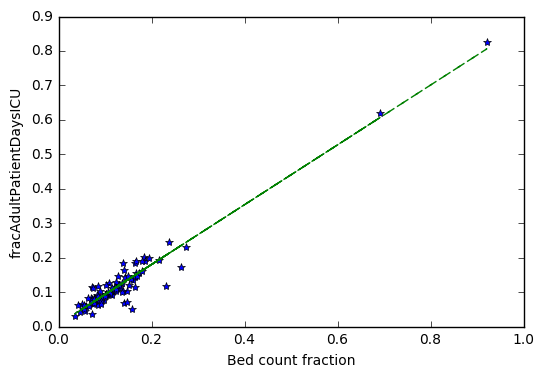

slope: 0.868205043174
intercept: 0.00631190005449
std_err: 0.0236990318659
r_value: 0.968744365171
p_value: 4.60380192894e-55
----------------------


In [9]:
lFapd = findThoseWithValid('fracAdultPatientDaysICU')
lBeds = findThoseWithValid('nBedsICU')
workL = [k for k in lBeds if k in lFapd]
xL = [float(facDict[k]['nBedsICU']['value'])/float(facDict[k]['nBeds']['value']) for k in workL]
yL = [facDict[k]['fracAdultPatientDaysICU']['value'] for k in workL]
slope, intercept, r_value, p_value, std_err = stats.linregress(xL,yL)
yFit = [intercept + (x * slope) for x in xL]
plt.xlabel('Bed count fraction')
plt.ylabel('fracAdultPatientDaysICU')
plt.plot(xL, yL, '*')
plt.plot(xL, yFit, '--')
plt.show()
print 'slope: %s' % slope
print 'intercept: %s' % intercept
print 'std_err: %s' % std_err
print 'r_value: %s' % r_value
print 'p_value: %s' % p_value
print '----------------------'
targetL = findThoseWithoutValid('fracAdultPatientDaysICU')
targetL.sort()
for abbrev in targetL:
    if abbrev in findThoseWithValid('nBedsICU'):
        print '%s, %f,' % (abbrev, (slope*(getVal(abbrev,'nBedsICU')/getVal(abbrev,'nBeds')) + intercept))
    else:
        print '%s,,no nBedsICU' % abbrev

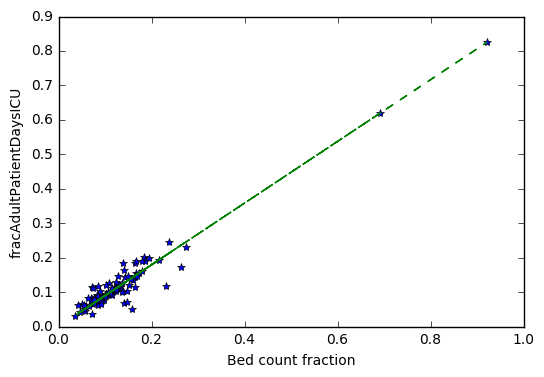

slope: 0.895575577593
intercept: 0.0
std_err: 0.0257098200209
----------------------


In [10]:
lFapd = findThoseWithValid('fracAdultPatientDaysICU')
lBeds = findThoseWithValid('nBedsICU')
workL = [k for k in lBeds if k in lFapd]
xL = [float(facDict[k]['nBedsICU']['value'])/float(facDict[k]['nBeds']['value']) for k in workL]
yL = [facDict[k]['fracAdultPatientDaysICU']['value'] for k in workL]
def term(x, y, slope):
    v = (y - (x*slope))
    return v*v
def chisqr(slope, xL, yL):
    return sum([term(x, y, slope) for x, y in zip(xL, yL)])
res = optimize.minimize_scalar(chisqr, args=(xL, yL))
#print res
slope = res.x
intercept = 0.0
yFit = [intercept + (x * slope) for x in xL]
plt.xlabel('Bed count fraction')
plt.ylabel('fracAdultPatientDaysICU')
plt.plot(xL, yL, '*')
plt.plot(xL, yFit, '--')
plt.show()
print 'slope: %s' % slope
print 'intercept: %s' % intercept
print 'std_err: %s' % math.sqrt(chisqr(slope, xL, yL)/(len(xL) - 1))
print '----------------------'
targetL = findThoseWithoutValid('fracAdultPatientDaysICU')
targetL.sort()
for abbrev in targetL:
    if abbrev in findThoseWithValid('nBedsICU'):
        print '%s, %f, %f' % (abbrev, (slope*(getVal(abbrev,'nBedsICU')/getVal(abbrev,'nBeds')) + intercept),
                             getVal(abbrev,'nBeds'))
    else:
        print '%s,,no nBedsICU' % abbrev

['VHS_3_H', 'SHER_1425_H', 'NORT_9600_H', 'MERC_2525_H', 'SILV_1900_H', 'THE_1740_H', 'CENT_25_H', 'PRES_1325_H', 'WAUK_1324_H', 'EDWA_801_H', 'ADVO_3815_H', 'VHS_4646_H', 'THE_1_H', 'VHS_3249_H', 'ROSE_45_H', 'NORT_777_H', 'LOYO_2160_H', 'MEMO_3701_H', 'ADVE_5101_H', 'ADVO_4440_H', 'PRES_7435_H', 'ADVO_836_H', 'PRES_77_H', 'ADVE_701_H', 'SAIN_2875_H', 'VHS_1225_H', 'GOTT_701_H', 'NORT_2650_H', 'ALEX_800_H', 'MIDW_1430_H', 'COPL_2000_H', 'MORR_150_H', 'MOUN_2028_H', 'FRAN_20201_H', 'FRAN_1423_H', 'THOR_850_H', 'ADVO_1775_H', 'COOK_1901_H', 'RUSH_520_H', 'COMM_5645_H', 'ST_326_H', 'NORT_4201_H', 'KISH_ONE_H', 'RIVE_350_H', 'JACK_7531_H', 'NORT_251_H', 'SWED_5145_H', 'ADVE_120_H', 'LORE_645_H', 'ADVO_2320_H', 'DELN_300_H', 'NORW_1044_H', 'VALL_1302_H', 'PRES_333_H', 'JOSE_1127_H', 'ADVO_801_H', 'THE_5841_H', 'PALO_12251_H', 'HOLY_2701_H', 'PRES_500_H', 'PRES_355_H', 'LITT_2800_H', 'SOUT_8012_H', 'PRES_1127_H', 'NORT_800_H', 'ST_1555_H', 'ADVO_450_H', 'ADVE_500_H', 'MSMC_12935_H', 'ADVO_1

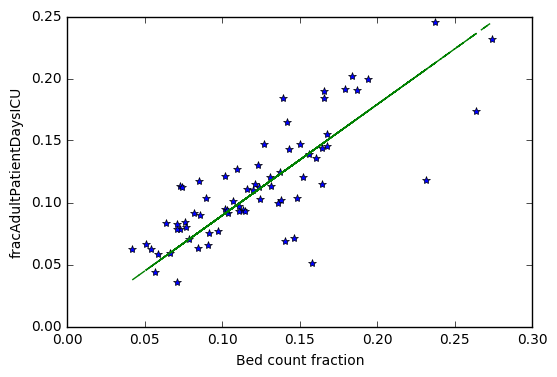

slope: 0.895575586139
intercept: 0.0
std_err: 0.0289897866863
------RegressionSamplesValues----------------
ADVE_120_H, 0.120757, 204.0, 0.151960784314,
ADVE_500_H, 0.121207, 118.0, 0.101694915254,
ADVE_5101_H, 0.189704, 163.0, 0.165644171779,
ADVE_701_H, 0.091759, 122.0, 0.0819672131148,
ADVO_1775_H, 0.113654, 464.0, 0.131465517241,
ADVO_17800_H, 0.103791, 224.0, 0.0892857142857,
ADVO_2320_H, 0.082436, 170.0, 0.0705882352941,
ADVO_3815_H, 0.183983, 266.0, 0.165413533835,
ADVO_4440_H, 0.190898, 551.0, 0.186932849365,
ADVO_450_H, 0.147229, 133.0, 0.15037593985,
ADVO_801_H, 0.080382, 221.0, 0.0769230769231,
ADVO_836_H, 0.102331, 268.0, 0.138059701493,
ALEX_800_H, 0.091860, 347.0, 0.103746397695,
CENT_25_H, 0.130177, 260.0, 0.123076923077,
COMM_5645_H, 0.112699, 269.0, 0.0743494423792,
COOK_1901_H, 0.173414, 326.0, 0.263803680982,
COPL_2000_H, 0.099657, 162.0, 0.135802469136,
DELN_300_H, 0.165113, 141.0, 0.141843971631,
EDWA_801_H, 0.155010, 239.0, 0.167364016736,
FRAN_1423_H, 0.094239, 1

In [44]:
depKey = 'fracAdultPatientDaysICU'
lDep = findThoseWithValid(depKey)
range = (0.0, 1000.0)
indepKey = 'nBeds'
lIndep = findThoseWithValid(indepKey)
workL = [k for k in lIndep if k in lDep and getVal(k, indepKey) >= range[0] and getVal(k, indepKey) < range[1]]
print workL
xL = [getVal(k, 'nBedsICU')/getVal(k, 'nBeds') for k in workL]
yL = [getVal(k, depKey) for k in workL]
pairs = zip(xL, yL)
def term(x, y, slope):
    v = (y - (x*slope))
    return v*v
def chisqr(slope, pairs):
    return sum([term(x, y, slope) for x, y in pairs])
res = optimize.minimize_scalar(chisqr, args=pairs)
#print res
slope = res.x
intercept = 0.0
yFit = [intercept + (x * slope) for x in xL]
plt.xlabel('Bed count fraction')
plt.ylabel(depKey)
plt.plot(xL, yL, '*')
plt.plot(xL, yFit, '--')
plt.show()
print 'slope: %s' % slope
print 'intercept: %s' % intercept
print 'std_err: %s' % math.sqrt(chisqr(slope, pairs)/(len(pairs) - 1))
print '------RegressionSamplesValues----------------'
targetL = findThoseWithValid(depKey)
targetL = [abbrev for abbrev in targetL if abbrev in findThoseWithValid('nBeds')]
targetL = [abbrev for abbrev in targetL if abbrev in findThoseWithValid('nBedsICU')]
targetL = [abbrev for abbrev in targetL if getVal(abbrev, indepKey) >= range[0] and getVal(abbrev, indepKey) < range[1]]
targetL.sort()
for abbrev in targetL:
    print '%s, %f, %s, %s,' % (abbrev,
                               getVal(abbrev,depKey),
                               getVal(abbrev,'nBeds'),
                               (getVal(abbrev,'nBedsICU')/getVal(abbrev,'nBeds')))
print '------ExtrapolatedValues----------------'
targetL = findThoseWithoutValid(depKey)
targetL = [abbrev for abbrev in targetL if getVal(abbrev, indepKey) >= range[0] and getVal(abbrev, indepKey) < range[1]]
targetL.sort()
for abbrev in targetL:
    if abbrev in findThoseWithValid('nBedsICU'):
        print '%s, %f, %s, %s,' % (abbrev,
                                   (slope*(getVal(abbrev,'nBedsICU')/getVal(abbrev,'nBeds')) + intercept),
                                   getVal(abbrev,'nBeds'),
                                   (getVal(abbrev,'nBedsICU')/getVal(abbrev,'nBeds')))
    else:
        print '%s,,,,no %s' % (abbrev, 'nBedsICU')

In [13]:

print len(workL)
print len(isHospital)

90
90


In [14]:
print findThoseWithoutValid('nBedsICU')

[]


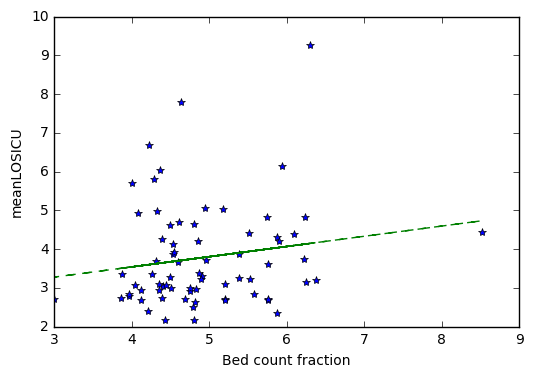

In [15]:
depKey = 'meanLOSICU'
lDep = findThoseWithValid(depKey)
lBeds = findThoseWithValid('nBedsICU')
workL = [k for k in lBeds if k in lDep]
#xL = [getVal(k, 'nBedsICU')/getVal(k, 'nBeds') for k in workL]
xL = [getVal(k, 'meanLOS') for k in workL]
yL = [facDict[k][depKey]['value'] for k in workL]
slope, intercept, r_value, p_value, std_err = stats.linregress(xL,yL)
yFit = [intercept + (x * slope) for x in xL]
plt.xlabel('Bed count fraction')
plt.ylabel(depKey)
plt.plot(xL, yL, '*')
plt.plot(xL, yFit, '--')
plt.show()

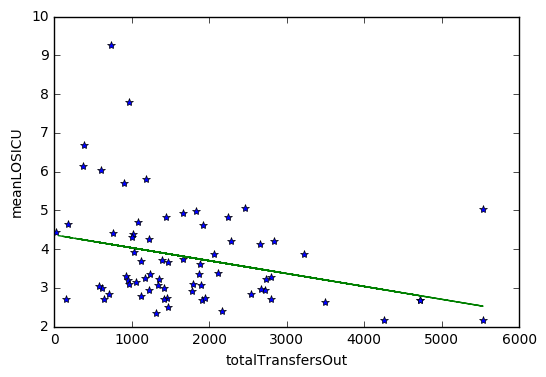

slope: -0.000332449445176
intercept: 4.36420263896
std_err: 0.000128624733012
r_value: -0.29710463444
p_value: 0.0118659335276


In [16]:
depKey = 'meanLOSICU'
lDep = findThoseWithValid(depKey)
indepKey = 'totalTransfersOut'
lIndep = findThoseWithValid(indepKey)
workL = [k for k in lIndep if k in lDep]
xL = [getVal(k, indepKey) for k in workL]
yL = [getVal(k, depKey) for k in workL]
slope, intercept, r_value, p_value, std_err = stats.linregress(xL,yL)
yFit = [intercept + (x * slope) for x in xL]
plt.xlabel(indepKey)
plt.ylabel(depKey)
plt.plot(xL, yL, '*')
plt.plot(xL, yFit, '--')
plt.show()
print 'slope: %s' % slope
print 'intercept: %s' % intercept
print 'std_err: %s' % std_err
print 'r_value: %s' % r_value
print 'p_value: %s' % p_value


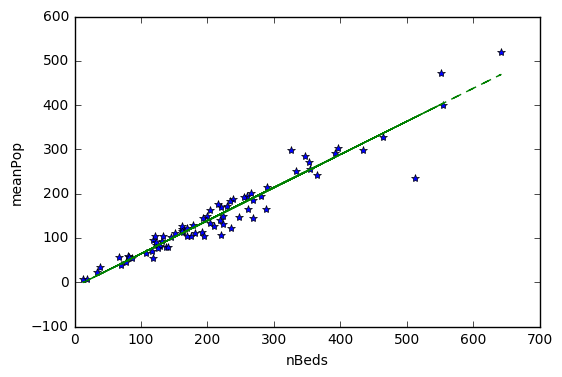

slope: 0.746747016753
intercept: -10.3828292868
std_err: 0.0244206131928
r_value: 0.963111004474
p_value: 2.33822158602e-43
----------------------
AURO_10400_H, 44.876450,
FRAN_1201_H, 165.849467,
FRAN_24_H, 110.590187,
FRAN_301_H, 126.271875,
FRAN_5454_H, 193.479106,
FRAN_701_H, 30.688257,
INDI_1007_H, 138.966574,
JASP_1104_H, 11.272834,
MUNS_901_H, 331.627304,
PINN_9301_H, 3.058617,
PORT_85_H, 214.388023,
STC_4321_H, 206.173806,
STM_1500_H, 138.219827,
THE_600_H, 183.771395,
UNIT_6308_H, 177.797419,


In [29]:
depKey = 'meanPop'
lDep = findThoseWithValid(depKey)
indepKey = 'nBeds'
lIndep = findThoseWithValid(indepKey)
workL = [k for k in lIndep if k in lDep]
xL = [getVal(k, indepKey) for k in workL]
yL = [getVal(k, depKey) for k in workL]
slope, intercept, r_value, p_value, std_err = stats.linregress(xL,yL)
yFit = [intercept + (x * slope) for x in xL]
plt.xlabel(indepKey)
plt.ylabel(depKey)
plt.plot(xL, yL, '*')
plt.plot(xL, yFit, '--')
plt.show()
print 'slope: %s' % slope
print 'intercept: %s' % intercept
print 'std_err: %s' % std_err
print 'r_value: %s' % r_value
print 'p_value: %s' % p_value
print '----------------------'
targetL = findThoseWithoutValid(depKey)
targetL.sort()
for abbrev in targetL:
    if abbrev in findThoseWithValid(indepKey):
        print '%s, %f,' % (abbrev, (slope*(getVal(abbrev,indepKey)) + intercept))
    else:
        print '%s,,no %s' % indepKey

In [18]:
print getVal('THE_600_H', 'nBeds')

260.0


In [19]:
l = findThoseWithValid('meanLOSICU')
print np.mean([getVal(k, 'meanLOSICU') for k in l])
print np.median([getVal(k, 'meanLOSICU') for k in l])

3.78000936322
3.29501268


In [20]:
l = [(getVal(k, 'nBeds'), k) for k in findThoseWithValid('nBeds') if k in findThoseWithValid('fracAdultPatientDaysICU')]
l.sort()
print l

[(13.0, 'BETH_5025_H'), (18.0, 'PINN_9301_H'), (19.0, 'VALL_1302_H'), (29.0, 'JASP_1104_H'), (34.0, 'MERC_901_H'), (38.0, 'ELMH_200_H'), (55.0, 'FRAN_701_H'), (67.0, 'NORT_660_H'), (70.0, 'MIDW_1430_H'), (74.0, 'AURO_10400_H'), (77.0, 'MORR_150_H'), (81.0, 'MEMO_3701_H'), (82.0, 'KISH_ONE_H'), (87.0, 'ROSE_45_H'), (108.0, 'SAIN_2875_H'), (117.0, 'RUSH_520_H'), (118.0, 'ADVE_500_H'), (118.0, 'NORT_777_H'), (121.0, 'MSMC_12935_H'), (122.0, 'ADVE_701_H'), (123.0, 'VHS_1225_H'), (125.0, 'SOUT_8012_H'), (129.0, 'PRES_500_H'), (131.0, 'NORW_1044_H'), (133.0, 'ADVO_450_H'), (137.0, 'THOR_850_H'), (141.0, 'DELN_300_H'), (145.0, 'NORT_9600_H'), (152.0, 'FRAN_20201_H'), (162.0, 'COPL_2000_H'), (162.0, 'FRAN_24_H'), (162.0, 'NORT_4201_H'), (162.0, 'VHS_3_H'), (163.0, 'ADVE_5101_H'), (169.0, 'LORE_645_H'), (170.0, 'ADVO_2320_H'), (176.0, 'ST_326_H'), (178.0, 'PRES_77_H'), (181.0, 'WAUK_1324_H'), (183.0, 'FRAN_301_H'), (192.0, 'JACK_7531_H'), (194.0, 'FRAN_1423_H'), (195.0, 'PRES_355_H'), (199.0, '

In [21]:
def innerTermCompare(oldTerm, newTerm, preamble=None):
    if preamble is None:
        preamble = ''
    # print '%s %s -> %s' % (preamble, oldTerm, newTerm)
    if isinstance(oldTerm, types.DictType):
        if isinstance(newTerm, types.DictType):
            allKeys = set(newTerm.keys() + oldTerm.keys())
            for key in allKeys:
                if key in oldTerm:
                    if key in newTerm:
                        if newTerm[key] != oldTerm[key]:
                            newPreamble = '%s %s: ' % (preamble, key)
                            innerTermCompare(oldTerm[key], newTerm[key], preamble=newPreamble)
                    else:
                        print '%s %s: this key was deleted' % (preamble, key)
                elif key in newTerm:
                    print '%s %s: this key was added' % (preamble, key)
                else:
                    raise RuntimeError('Vanishing key %s' % key)
        else:
            print '%s%s -> %s' % (preamble, oldTerm, newTerm)
    elif isinstance(oldTerm, types.ListType):
        if isinstance(newTerm, types.ListType):
            oldL = oldTerm[:]
            oldL.sort()
            newL = newTerm[:]
            newL.sort()
            idx = 0
            while oldL and newL:
                innerTermCompare(oldL.pop(0), newL.pop(0), preamble='%s %s:'%(preamble, idx))
                idx += 1
            if oldL:
                print '%s: lost %s in update' % (preamble, oldL)
            elif newL:
                print '%s: gained %s in update' % (preamble, newL)
            else:
                pass  # lists have been compared
        else:
            print '%s%s -> %s' % (preamble, oldTerm, newTerm)
    else:
        if oldTerm != newTerm:
            print '%s%s -> %s' % (preamble, oldTerm, newTerm)


    
def termCompare(abbrev, key):
    if abbrev in facDict:
        if abbrev in updatedFacDict:
            if key in facDict[abbrev]:
                if key in updatedFacDict[abbrev]:
                    oldTerm = facDict[abbrev][key]
                    newTerm = updatedFacDict[abbrev][key]
                    if newTerm != oldTerm:
                        innerTermCompare(oldTerm, newTerm, '%s: %s: ' % (abbrev, key))
                else:
                    pass
            else:
                if key in updatedFacDict[abbrev]:
                    print '%s: %s field was added in update' % (abbrev, key)
                else:
                    pass # no such abbrev key pair exists
        else:
            pass  # This abbrev was not updated
    elif abbrev in updatedFacDict:
        print '%s record was newly created in the update' % abbrev
    else:
        pass  # no such entry exists
        
allKeySet, recs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfacts'))
facDict = {r['abbrev']:r for r in recs}

kL, uRecs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfactsUpdated'))
updatedFacDict= {r['abbrev']:r for r in uRecs}

for abbrev, rec in facDict.items():
    if abbrev in updatedFacDict:
        uRec = updatedFacDict[abbrev]
        allKeys = set(rec.keys() + uRec.keys())
        for key in allKeys:
            if key in rec:
                if key in uRec:
                    termCompare(abbrev, key)
                else:
                    print '%s: no %s in updated rec' % (abbrev, key)
            else:
                print '%s: %s key was added' % (abbrev, key)

print '----DONE----'


----DONE----


In [22]:
findThoseWithoutValid('meanLOSICU')


['PINN_9301_H',
 'MERC_901_H',
 'BETH_5025_H',
 'FRAN_5454_H',
 'MUNS_901_H',
 'ELMH_200_H',
 'FRAN_1201_H',
 'FRAN_24_H',
 'THE_600_H',
 'FRAN_301_H',
 'JASP_1104_H',
 'STM_1500_H',
 'STC_4321_H',
 'AURO_10400_H',
 'NORT_660_H',
 'UNIT_6308_H',
 'PORT_85_H',
 'INDI_1007_H',
 'FRAN_701_H']

In [28]:
l1 = findThoseWithoutValid('meanPop')
l2 = findThoseWithValid('nBeds')
for abbrev in l1:
    print facDict[abbrev]['address']


9301 CONNECTICUT DR, CROWN POINT, Lake County, IN 46307, USA
5454 S HOHMAN AVE, HAMMOND, Lake County, IN 46320, USA
901 MACARTHUR BLVD, MUNSTER, Lake County, IN 46321, USA
1201 S MAIN ST, CROWN POINT, Lake County, IN 46307, USA
24 JOLIET ST, DYER, Lake County, IN 46311, USA
600 GRANT ST, GARY, Lake County, IN 46402, USA
301 W HOMER ST, MICHIGAN CITY, LaPorte County, IN 46360, USA
1104 E GRACE ST, RENSSELAER, Jasper County, IN 47978, USA
1500 S LAKE PARK AVENUE, HOBART, Lake County, IN 46342, USA
4321 FIR ST, EAST CHICAGO, Lake County, IN 46312, USA
10400 75TH ST, KENOSHA, Kenosha County, WI 53142, USA
6308 8TH AVE, KENOSHA, Kenosha County, WI 53143, USA
85 E US HIGHWAY 6, VALPARAISO, Porter County, IN 46383, USA
1007 LINCOLNWAY, LA PORTE, LaPorte County, IN 46350, USA
701 SUPERIOR AVE, MUNSTER, Lake County, IN 46321, USA


In [24]:
print facDict['ELMH_200_H']['nBeds']


OrderedDict([('prov', 'Geocoded_LOSCMSAHQ_2010Cohort_LOS_Bedsize_v082116.xlsx:BedLOS:$S (includes ICU)'), ('value', 38)])


In [30]:
print findThoseWithoutValid('meanPop')

['PINN_9301_H', 'FRAN_5454_H', 'MUNS_901_H', 'FRAN_1201_H', 'FRAN_24_H', 'THE_600_H', 'FRAN_301_H', 'JASP_1104_H', 'STM_1500_H', 'STC_4321_H', 'AURO_10400_H', 'UNIT_6308_H', 'PORT_85_H', 'INDI_1007_H', 'FRAN_701_H']


In [47]:
for abbrev in findThoseWithoutValid('meanPop'):
    print '%s: %s' % (abbrev, getVal(abbrev, 'meanPop'))

PINN_9301_H: None
FRAN_5454_H: None
MUNS_901_H: None
FRAN_1201_H: None
FRAN_24_H: None
THE_600_H: None
FRAN_301_H: None
JASP_1104_H: None
STM_1500_H: None
STC_4321_H: None
AURO_10400_H: None
UNIT_6308_H: None
PORT_85_H: None
INDI_1007_H: None
FRAN_701_H: None
